In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import fastcluster

In [60]:
ft = pd.read_csv("./HZV029_RP_neg_preferred.tsv", sep="\t")

/var/folders/pz/1h09fp594z13_f873f8p_w20vw6015/T/ipykernel_69755/3021838956.py:1: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(np.array(np.log10(ft["peak_area"])), bw=0.5)


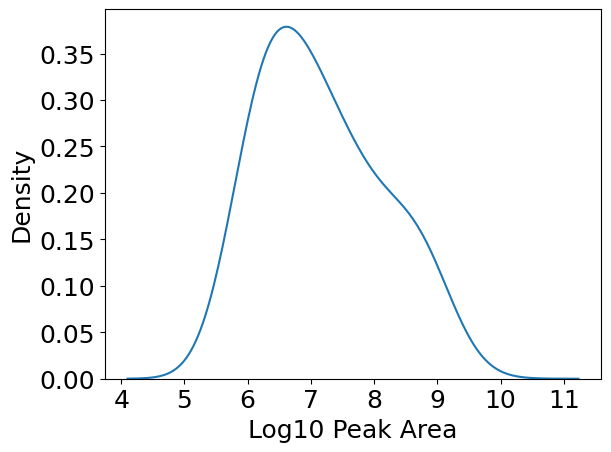

In [54]:
sns.kdeplot(np.array(np.log10(ft["peak_area"])), bw=0.5)
plt.xlabel("Log10 Peak Area", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


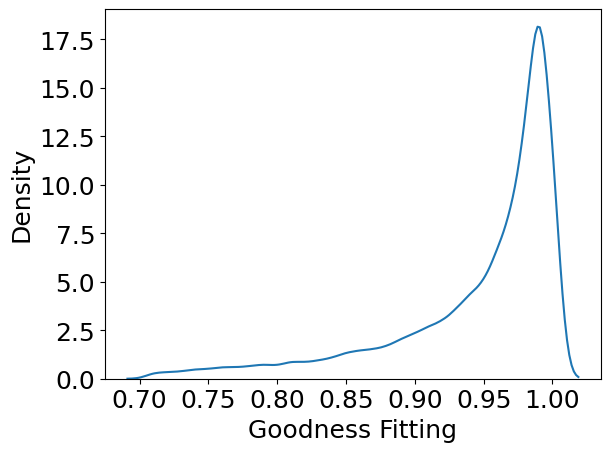

In [97]:
sns.kdeplot(np.array(ft["goodness_fitting"]), bw_method=.1, common_norm=True)
plt.xlabel("Goodness Fitting", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

/var/folders/pz/1h09fp594z13_f873f8p_w20vw6015/T/ipykernel_69755/3626419781.py:1: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(np.array(ft["cSelectivity"]), bw=0.1)


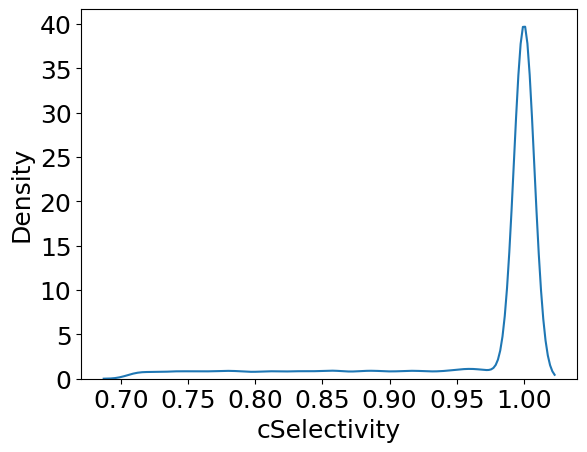

In [63]:
sns.kdeplot(np.array(ft["cSelectivity"]), bw=0.1)
plt.xlabel("cSelectivity", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

/var/folders/pz/1h09fp594z13_f873f8p_w20vw6015/T/ipykernel_69755/3099846945.py:1: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(np.array(np.log10(ft["snr"])), bw=0.1)


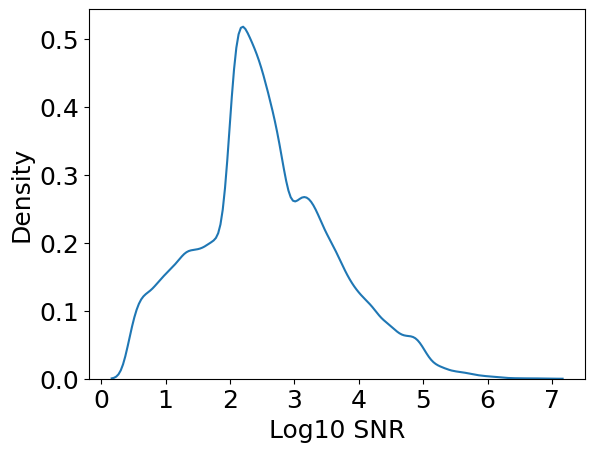

In [64]:
sns.kdeplot(np.array(np.log10(ft["snr"])), bw=0.1)
plt.xlabel("Log10 SNR", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

/var/folders/pz/1h09fp594z13_f873f8p_w20vw6015/T/ipykernel_69755/305038289.py:1: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot(np.array(ft["detection_counts"]), bw=0.1)


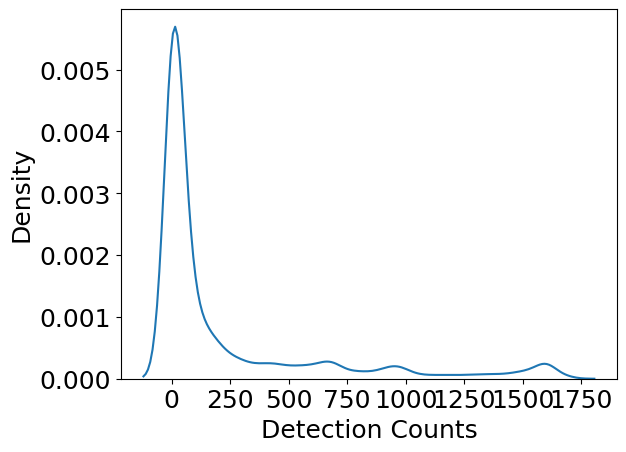

In [9]:
sns.kdeplot(np.array(ft["detection_counts"]), bw=0.1)
plt.xlabel("Detection Counts", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [73]:
import json
import matplotlib.colors as mcolors
from sys import setrecursionlimit
import scipy
setrecursionlimit(100000)

ft = pd.read_csv("./HZV029_RP_neg_preferred.tsv", sep="\t")
exp_obj = json.load(open("./HZV029_RP_neg_batch_corrected_experiment.json"))

color_map = {
    'blank': 'k',
    'blank_standard': 'grey',
    'blank_standard_dda': 'yellow',
    'qstd_standard': 'red',
    'qstd_standard_dda': 'orange',
    'nist': 'green',
    'pooled': 'purple',
    'pooled_dda': 'pink',
    'unknown': 'plum',
    'pooled': 'darkviolet'
}
batch_color_map = {
    1: "mistyrose",
    2: "lightcoral",
    3: "coral",
    4: "lightsalmon",
    5: "salmon",
    6: "darksalmon",
    7: "tomato",

    8: "lightcyan",
    9: "powderblue",
    10: "lightblue",
    11: "lightskyblue",
    12: "skyblue",
    13: "deepskyblue",
    14: "cornflowerblue",
    15: "dodgerblue",
    16: "royalblue",
    17: "blue"
}

col_colors = [[], []]
sample_columns = ft.columns[11:]
to_include = []
for sample in sample_columns:
    og_sample = sample
    sample = sample #.split("___")[-1]
    found = False
    for acquisition in exp_obj["acquisitions"]:
        if sample in acquisition['metadata_tags']['File Name']:
            if acquisition['metadata_tags']['Sample Type'] in ['pooled', 'unknown']:
                found = True
                col_colors[0].append(color_map[acquisition['metadata_tags']['Sample Type']])
                col_colors[1].append(batch_color_map[int(acquisition['metadata_tags']['batch'])])
                to_include.append(og_sample)
                break
assert(len(to_include) == len(col_colors[0]))
            
working_table = ft.copy()
corr_matrix = np.zeros((len(to_include), len(to_include)))
working_table = np.log2(working_table[to_include] + 1)
for i, s1 in enumerate(to_include):
    val_s1 = working_table[s1]
    for j, s2 in enumerate(to_include):
        if corr_matrix[j][i] != 0:
            corr_matrix[i][j] = corr_matrix[j][i]
        else:
            corr = np.corrcoef(val_s1, working_table[s2])
            corr_matrix[i][j] = corr[0][1]
    


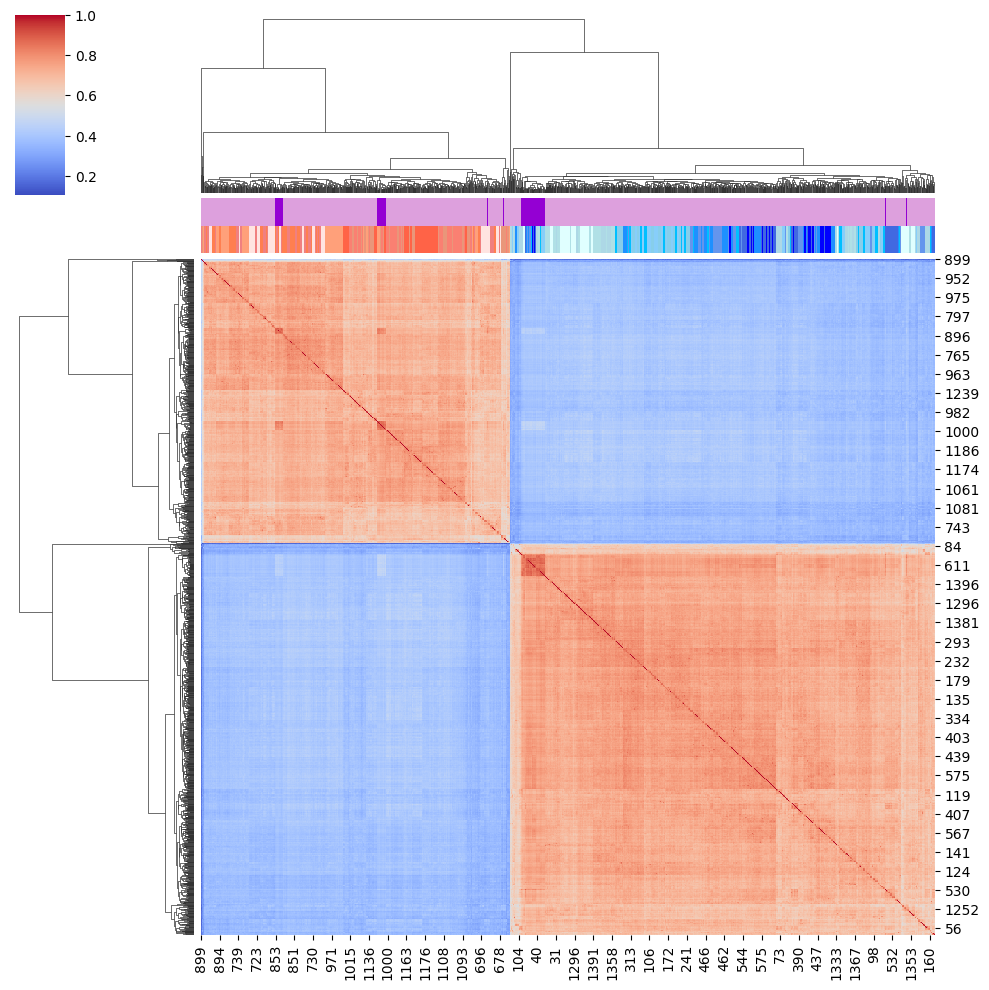

In [74]:
sns.clustermap(corr_matrix, col_colors=col_colors, cmap='coolwarm')

In [75]:
df = []
for i, s1 in enumerate(to_include):
    row = {"sample": s1}
    for j, s2 in enumerate(to_include):
        row[s2] = corr_matrix[i][j]
    df.append(row)
pd.DataFrame(df).to_csv("correlation_matrix_wo_batch_corr.csv", index=False)

    id_number        mz   rtime  rtime_left_base  rtime_right_base  \
0          F1   80.9168   27.74            23.15             32.37   
1         F11   82.9719   27.74            23.15             32.37   
2         F15  165.0418   73.72            69.33             77.12   
3         F22  165.0558   94.29            89.51             98.99   
4         F32  165.8372   28.91            24.29             32.76   
..        ...       ...     ...              ...               ...   
463    F30062  578.3020  163.62           159.04            168.19   
464    F30072  627.3755  107.51           102.90            112.10   
465    F30507  632.3182  165.15           160.57            169.73   
466    F30595  633.3216  165.15           160.57            169.73   
467    F30933  710.2611  164.77           160.19            169.34   

     parent_masstrack_id   peak_area  cSelectivity  goodness_fitting     snr  \
0                      1   875794322          1.00              0.99   20293   

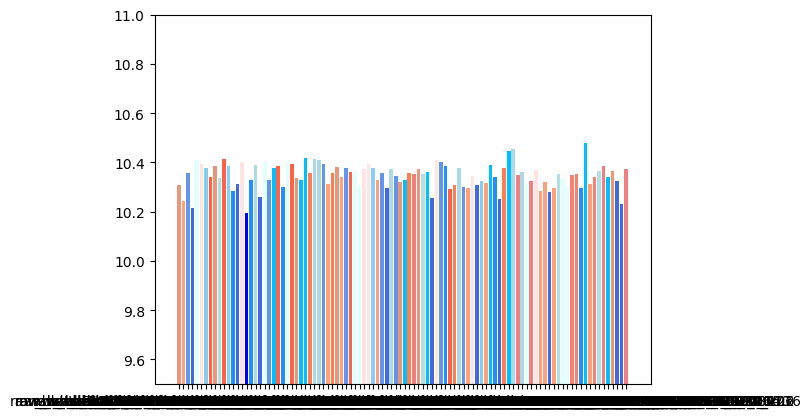

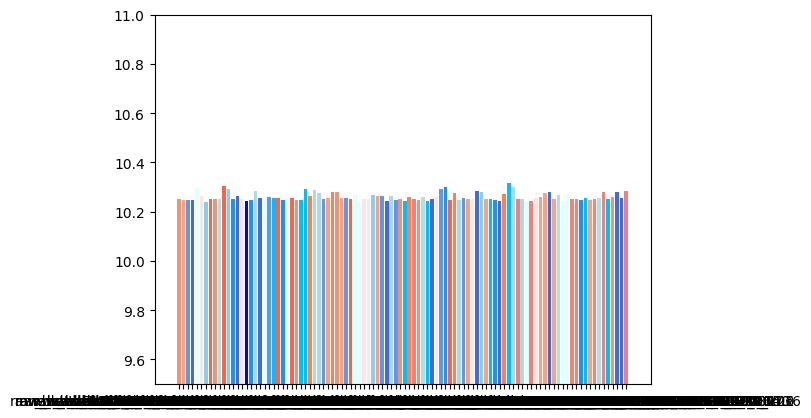

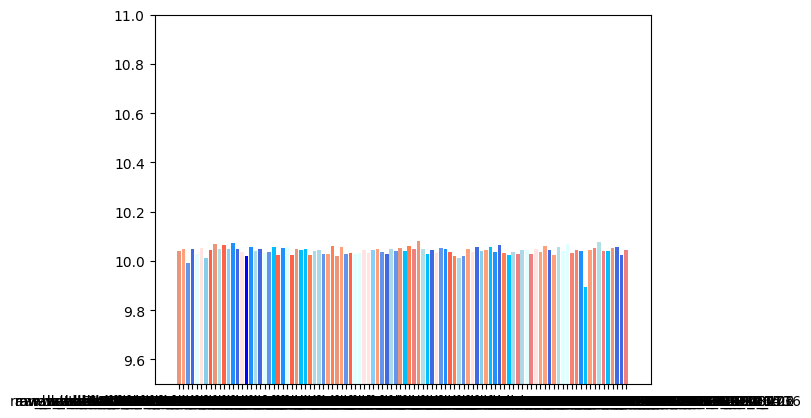

In [78]:
import random

normalized = pd.read_csv("./HZV029_RP_neg_normalized.tsv", sep="\t")
batch_corrected = pd.read_csv("./HZV029_RP_neg_batch_corrected.tsv", sep="\t")
print(batch_corrected)

in_both = []
for x in normalized.columns:
    if x in ft.columns[11:] and x in normalized.columns and x in batch_corrected.columns:
        in_both.append(x)

sample_color_by_batch = {}
sample_color_by_type = {}
for acquisition in exp_obj["acquisitions"]:
    sample_color_by_batch[acquisition['metadata_tags']["File Name"].rstrip(".mzML")] = batch_color_map[int(acquisition['metadata_tags']['batch'])]


to_plot = random.sample(in_both, 100)
selected_ft = ft[to_plot]
TICs = np.nansum(selected_ft, axis=0)
log_TICs = np.log10(TICs)
plt.ylim([9.5, 11])
plt.bar(to_plot, log_TICs, color=[sample_color_by_batch[y] for y in to_plot])
plt.show()

selected_ft = normalized[[x for x in to_plot]]
TICs = np.nansum(selected_ft, axis=0)
log_TICs = np.log10(TICs)
plt.ylim([9.5, 11])
plt.bar(to_plot, log_TICs, color=[sample_color_by_batch[y] for y in to_plot])
plt.show()

selected_ft = batch_corrected[[x for x in to_plot]]
TICs = np.nansum(selected_ft, axis=0)
log_TICs = np.log10(TICs)
plt.ylim([9.5, 11])
plt.bar(to_plot, log_TICs, color=[sample_color_by_batch[y] for y in to_plot])
plt.show()



['powderblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue

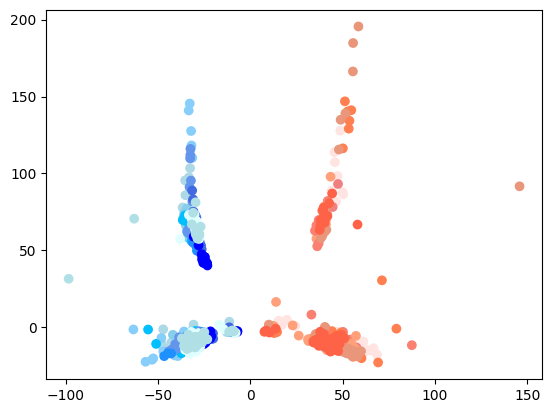

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ft = pd.read_csv("./HZV029_RP_neg_preferred.tsv", sep="\t")
batch_lookup = {}

def do_PCA(table, skip_log=True):
    """
    Perform PCA on provided feature table, optionally log transform
    it first. 

    :param figure_params: dictionary with figure params

    :return: QAQC_result dict
    """
    samples = table.columns[11:]
    colors = []
    for s in samples:
        if s not in batch_lookup:
            batch_no = int(s.split("batch")[-1].split('_')[0])
            colors.append(batch_color_map[batch_no])
            batch_lookup[s] = batch_no
            batch_lookup[s.split('___')[-1]] = batch_no
        else:
            print(batch_lookup)
            colors.append(batch_lookup[s])

    sample_ftable = table[samples].T.copy()
    scaler = StandardScaler()
    pca_embedder = PCA(n_components=2)
    #if not skip_log:
    #    sample_ftable = np.log2(sample_ftable+1)
    pca_embedding = pca_embedder.fit_transform(scaler.fit_transform((sample_ftable)))
    Xs = [z[0] for z in pca_embedding]
    Ys = [z[1] for z in pca_embedding]
    print(colors)
    plt.scatter(Xs, Ys, c=colors)
    plt.show()

do_PCA(ft)

3.5702589424307516 -1.5555982033011837 powderblue
13.75110625548177 19.428240208501382 lightblue
-15.514976594160846 3.4742822634665464 lightblue
-10.67359685348684 2.404852479753779 lightblue
-10.639770409260981 -0.47935335171279825 lightblue
-8.499472249340444 0.15862251201901761 lightblue
-16.38946400444795 -2.3969261248861433 lightblue
-8.574410669140939 1.1596848590695317 lightblue
-11.862317335150346 -3.586304752433389 lightblue
-7.791269771578066 1.2514436414926187 lightblue
-5.786907185589234 0.5604721877911781 lightblue
3.326399364691742 -9.159927460259166 lightblue
-4.192529990381861 -7.320393444984351 lightblue
-7.339738282715106 -6.144356174512533 lightblue
-11.774553680658512 -13.310468557595781 lightblue
-5.4634338017273025 -7.10622864858783 lightblue
-3.091894389372718 -9.274396817753 lightblue
-2.0105259577909362 -6.572720180555173 lightblue
-2.7901242358247607 -6.296143682522952 lightblue
-1.2514716429128885 3.676421733724738 lightblue
-9.57244181612939 5.7702825038005

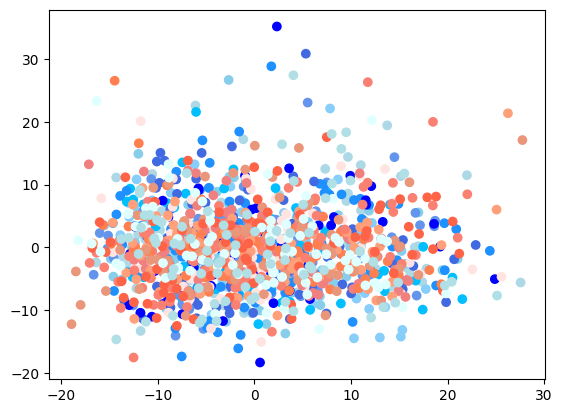

In [83]:
import matplotlib.pyplot as plt

bc = pd.read_csv("./HZV029_RP_neg_batch_corrected.tsv", sep="\t")
plt.clf()
def do_PCA(table):
    """
    Perform PCA on provided feature table, optionally log transform
    it first. 

    :param figure_params: dictionary with figure params

    :return: QAQC_result dict
    """
    samples = table.columns[11:]
    colors = []
    for s in samples:
        colors.append(batch_color_map[batch_lookup[s]])

    sample_ftable = table[samples].T.copy()
    scaler = StandardScaler()
    pca_embedder = PCA(n_components=2)
    pca_embedding = pca_embedder.fit_transform(scaler.fit_transform((sample_ftable)))
    Xs = [z[0] for z in pca_embedding]
    Ys = [z[1] for z in pca_embedding]
    for x,y,c in zip(Xs, Ys, colors):
        print(x,y,c)

    plt.scatter(Xs, Ys, c=colors)
    plt.show()

do_PCA(bc)

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


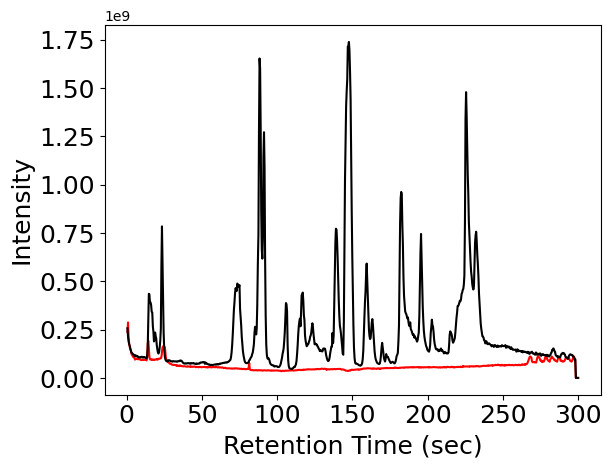

In [84]:
import pymzml
from intervaltree import IntervalTree
import matplotlib.pyplot as plt

def TIC(filepath_1, filepath_2):
    for path, color in zip([filepath_1, filepath_2], ['r', 'k']):
        mz_trees = [IntervalTree()] 
        rt_trees = [IntervalTree()] 
        mz_trees[0].addi(-np.inf, np.inf)
        rt_trees[0].addi(-np.inf, np.inf)
        bins = [[] for _ in mz_trees]
        rtimes = []
        for spec in pymzml.run.Reader(path):
            rtime = round(spec.scan_time[0] * 60, 3)
            rtimes.append(rtime)
            for bin in bins:
                bin.append(0)
            matches = [True if rt_tree.at(rtime) else False for rt_tree in rt_trees]
            match_mask = [i for i, match in enumerate(matches) if match]
            if match_mask:
                for peak in spec.peaks("centroided"):
                    mz = peak[0]
                    for match in match_mask:
                        if mz_trees[match].at(mz):
                            bins[match][-1] += float(peak[1])
        for i, bin in enumerate(bins):
            plt.plot(rtimes, bin, c=color)
    plt.ylabel("Intensity", fontsize=18)
    plt.xlabel("Retention Time (sec)", fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.show()

TIC("./batch5_MT_20210730_001.mzML", "./batch5_MT_20210730_003.mzML")

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


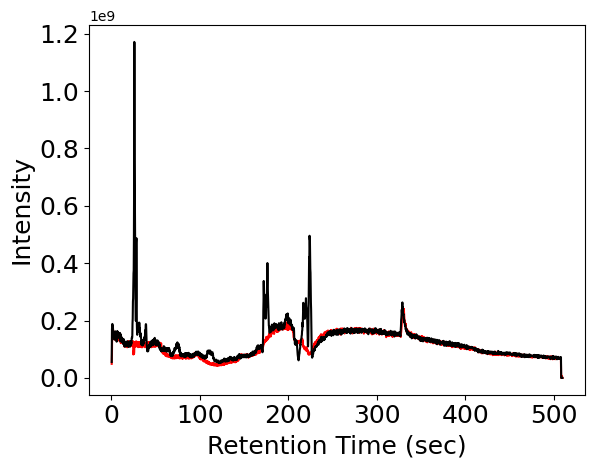

In [85]:
TIC("/Users/mitchjo/pcpfm/Analyses/Lipidomics_HR_LR/converted_acquisitions/MT_20230807_071.mzML", "/Users/mitchjo/pcpfm/Analyses/Lipidomics_HR_LR/converted_acquisitions/MT_20230807_069.mzML")

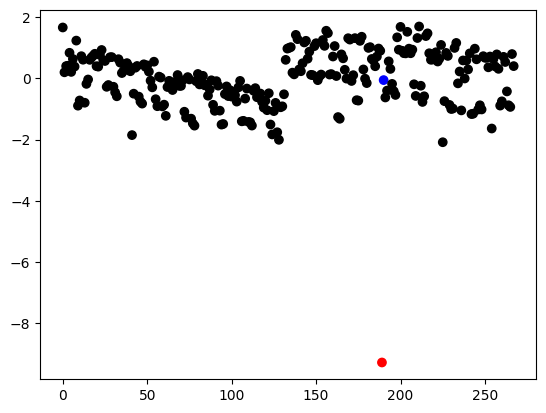

In [87]:
hr_lr_exp = json.load(open("./HZV029_QC_experiment.json"))
results = hr_lr_exp["qcqa_results"]["masked_preferred_unknowns"]['feature_count_z_scores']["Result"]

X = []
Y = []
Cs = []
for i, (key, value) in enumerate(results.items()):
    X.append(i)
    Y.append(value)
    if key == "batch5_MT_20210730_001":
        Cs.append('r')
    elif key == "batch5_MT_20210730_003":
        Cs.append('blue')
    else:
        Cs.append('k')


plt.scatter(X, Y, c=Cs)

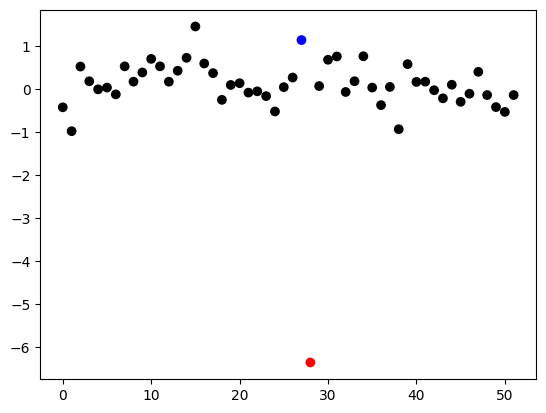

In [86]:
hr_lr_exp = json.load(open("./HZV029_lipidomics_experiment.json"))
results = hr_lr_exp["qcqa_results"]["masked_preferred_unknowns"]['feature_count_z_scores']["Result"]

X = []
Y = []
Cs = []
for i, (key, value) in enumerate(results.items()):
    X.append(i)
    Y.append(value)
    if key == "MT_20230807_071":
        Cs.append('r')
    elif key == "MT_20230807_069":
        Cs.append('blue')
    else:
        Cs.append('k')


plt.scatter(X, Y, c=Cs)